<a href="https://colab.research.google.com/github/philipp-lampert/mymandible/blob/main/data_science/05_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training

## Import

### Libraries

In [505]:
import numpy as np
import pandas as pd
import copy
from statistics import mean, stdev
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import make_scorer, matthews_corrcoef, f1_score, accuracy_score, average_precision_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import optuna
import shap
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

### Data

In [7]:
df_dropped_first_imp = pd.read_parquet('/Users/philipp.lampert/repositories/mymandible/data/dropped_first_imputed.parquet')
df_all_levels_imp = pd.read_parquet('/Users/philipp.lampert/repositories/mymandible/data/all_levels_imputed.parquet')

## Pipeline

### Preprocessing

In [242]:
def get_x_y(df, outcome, min_follow_up_days, scaler, drop_cols):

    df = df.drop(columns=drop_cols)
    first_outcome_var = df.columns.get_loc('days_to_follow_up')
    predictors = df.columns[:first_outcome_var].tolist()

    data = df[df['days_to_follow_up'] >= min_follow_up_days].copy()
    data['days_to_flap_loss'] = data['days_to_flap_loss'].fillna(10000)
    data = data[data['days_to_flap_loss'] >= min_follow_up_days]
    data = data[predictors + [outcome]].dropna()

    if scaler != 'None':
        numeric_columns = data[predictors].select_dtypes(np.number).columns.tolist()
        data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
        
    # Flip outcome values if n(positive class) > n(negative class)
    value_counts = data[outcome].value_counts()
    if value_counts[True] > value_counts[False]:
        data[outcome] = ~data[outcome]
        print('IMPORTANT: The outcome value was inversed due to the positive class being more frequent than the negative class. High SHAP values predict the non-occurence.\n')

    return data[predictors], data[outcome]

In [9]:
def avg(list):
    avg = sum(list) / len(list)
    return avg

### Scoring metrics

In [10]:
def optimized_accuracy(y_test, y_pred):
    thresholds = np.arange(0.05, 0.95, 0.05)
    best_acc = 0

    for threshold in thresholds:
        predicted_labels = (y_pred >= threshold).astype(int)
        acc = accuracy_score(y_test, predicted_labels)
        if acc > best_acc:
            best_acc = acc

    return best_acc

In [11]:
def optimized_f1(y_test, y_pred):
    thresholds = np.arange(0.05, 0.95, 0.05)
    best_f1 = 0

    for threshold in thresholds:
        predicted_labels = (y_pred >= threshold).astype(int)
        f1 = f1_score(y_test, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1

    return best_f1

In [12]:
def optimized_mcc(y_test, y_pred):
    thresholds = np.arange(0.05, 0.95, 0.05)
    best_mcc = -1

    for threshold in thresholds:
        predicted_labels = (y_pred >= threshold).astype(int)
        mcc = matthews_corrcoef(y_test, predicted_labels)
        if mcc > best_mcc:
            best_mcc = mcc

    return best_mcc

In [13]:
acc_scorer = make_scorer(optimized_accuracy, needs_proba=True)
f1_scorer = make_scorer(optimized_f1, needs_proba=True)
mcc_scorer = make_scorer(optimized_mcc, needs_proba=True)

### Nested Cross-Validation

In [474]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

In [481]:
def objective(trial, classifier, x, y):
    
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    classifier_obj = classifier(trial)
    
    scores = cross_validate(
        estimator=classifier_obj, 
        X=x, 
        y=y, 
        cv=inner_cv, 
        scoring=mcc_scorer, 
        n_jobs=-1
    )
    
    return scores['test_score'].mean() 

In [414]:
def nested_cv_optuna(outcome, model, min_follow_up_days, scaler, df, classifier, drop_cols):
    
    n_splits = 5
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    x, y = get_x_y(df=df, outcome=outcome, min_follow_up_days=min_follow_up_days, scaler=scaler, drop_cols=drop_cols)
    
    outer_scores = {
        'mcc': [],
        'f1': [],
        'acc': [],
        'pr_auc': [],
        'roc_auc': []
    }
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)   
    
    i = 0
    studies = {}
    best_params = []
    
    for i, (outer_train_index, outer_test_index) in enumerate(outer_cv.split(x, y)):
        
        x_train_outer, x_test_outer = x.iloc[outer_train_index], x.iloc[outer_test_index]
        y_train_outer, y_test_outer = y.iloc[outer_train_index], y.iloc[outer_test_index]
        
        studies[i] = optuna.create_study(direction='maximize', study_name=i)
        studies[i].optimize(lambda trial: objective(trial, classifier, x_train_outer, y_train_outer), n_trials=500)

        best_params.append(studies[i].best_params)
        current_model = copy.deepcopy(model)
        current_model.set_params(**best_params[-1])
        
        current_model.fit(x_train_outer, y_train_outer)
        y_pred_outer = current_model.predict_proba(x_test_outer)
        y_pred_outer = y_pred_outer[:, 1]
        y_test_outer = y_test_outer.astype('int')
        
        mcc = optimized_mcc(y_test_outer, y_pred_outer)
        f1 = optimized_f1(y_test_outer, y_pred_outer)
        acc = optimized_accuracy(y_test_outer, y_pred_outer)
        pr_auc = average_precision_score(y_test_outer, y_pred_outer)
        roc_auc = roc_auc_score(y_test_outer, y_pred_outer)

        outer_scores['mcc'].append(mcc)
        outer_scores['f1'].append(f1)
        outer_scores['acc'].append(acc)
        outer_scores['pr_auc'].append(pr_auc)
        outer_scores['roc_auc'].append(roc_auc)
        
        print(f"Optimized {i+1} out of {n_splits} models")
    
    print("")
    print("Mean F1: "f"{mean(outer_scores['f1']):.3f} ± {stdev(outer_scores['f1']):.3f}")
    print("Mean MCC: "f"{mean(outer_scores['mcc']):.3f} ± {stdev(outer_scores['mcc']):.3f}")  
    print("Mean Accuracy: "f"{mean(outer_scores['acc']):.3f} ± {stdev(outer_scores['acc']):.3f}")
    print("Mean PR AUC: "f"{mean(outer_scores['pr_auc']):.3f} ± {stdev(outer_scores['pr_auc']):.3f}")
    print("Mean ROC AUC: "f"{mean(outer_scores['roc_auc']):.3f} ± {stdev(outer_scores['roc_auc']):.3f}")
    
    print("")
    print(f"All F1 scores: {outer_scores['f1']}")
        
    return best_params, x, y

### SHAP-Values

In [540]:
def get_shap_rf(best_params, x, y):
    for i, params in enumerate(best_params):
        model = RandomForestClassifier(**params)
        model.fit(x, y)
        exp = shap.TreeExplainer(model)
        sv = exp.shap_values(x)
        shap.summary_plot(sv[1], x, max_display=11)
        shap.summary_plot(sv[1], x, max_display=11, plot_type='bar')

In [541]:
def get_shap_xgb(best_params, x, y):    
    sv = []
    exp = []
    for i, params in enumerate(best_params):
        model = XGBClassifier(**params)
        model.fit(x, y)
        exp.append(shap.TreeExplainer(model))
        sv.append(exp[-1](x))
        shap.plots.beeswarm(sv[-1], max_display=11)
        shap.plots.bar(sv[-1], max_display=11)

In [204]:
def get_avg_params(param_list):
    df = pd.DataFrame(param_list)
    numeric_averages = df.select_dtypes(include=['number']).median()
    categorical_modes = df.select_dtypes(exclude=['number']).mode().iloc[0]
    avg_params = {**numeric_averages, **categorical_modes}
    avg_params['max_depth'] = avg_params['max_depth'].astype('int')
    return avg_params

In [316]:
def get_base_values(selected_sv):
    bv = []
    for sv in selected_sv:
        bv.append(sv.base_values[0])
    return bv

## Model configuration

### Logistic Regression

In [19]:
def lr_newton_classifier(trial):
    
    solver_chosen = trial.suggest_categorical('solver', ['newton-cg', 'newton-cholesky'])
    C_chosen = trial.suggest_float('C', 1e-10, 1e10, log=True)
    class_weight_chosen = trial.suggest_categorical('class_weight', ['balanced', None])
    penalty_chosen = trial.suggest_categorical('penalty', ['l2'])
    
    classifier_obj = LogisticRegression(
        solver=solver_chosen, 
        C=C_chosen, 
        penalty=penalty_chosen, 
        class_weight=class_weight_chosen
    )
        
    return classifier_obj

In [20]:
def lr_liblinear_classifier(trial):
    
    solver_chosen = trial.suggest_categorical('solver', ['liblinear'])
    C_chosen = trial.suggest_float('C', 1e-10, 1e10, log=True)
    class_weight_chosen = trial.suggest_categorical('class_weight', ['balanced', None])
    penalty_chosen = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    classifier_obj = LogisticRegression(
        solver=solver_chosen, 
        C=C_chosen, 
        penalty=penalty_chosen, 
        class_weight=class_weight_chosen
    )
          
    return classifier_obj

In [463]:
def lr_statsmodels(outcome, min_follow_up_days, scaler, df, drop_cols):
    
    x, y = get_x_y(df=df, outcome=outcome, min_follow_up_days=min_follow_up_days, scaler=scaler, drop_cols=drop_cols)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = {
        'mcc': [],
        'f1': [],
        'acc': [],
        'pr_auc': [],
        'roc_auc': []
    }
    
    boolean_columns = x.select_dtypes(include=bool).columns
    x[boolean_columns] = x[boolean_columns].astype('int')
    numeric_columns = x.select_dtypes(include='number').columns
    x[numeric_columns] = x[numeric_columns].astype('float64')
    y = y.astype('int')
    
    x_columns = x.columns
    all_columns = "+".join(x_columns)
    formula = outcome +  '~' + all_columns
    
    for i, (train_index, test_index) in enumerate(cv.split(x, y)):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        data_train = pd.concat([x_train, y_train], axis=1)

        model = smf.logit(formula=formula, data=data_train).fit() 
        y_pred = model.predict(x_test)
        
        mcc = optimized_mcc(y_test, y_pred)
        f1 = optimized_f1(y_test, y_pred)
        acc = optimized_accuracy(y_test, y_pred)
        pr_auc = average_precision_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        scores['mcc'].append(mcc)
        scores['f1'].append(f1)
        scores['acc'].append(acc)
        scores['pr_auc'].append(pr_auc)
        scores['roc_auc'].append(roc_auc)
        
    print("")
    print("Mean F1: "f"{mean(scores['f1']):.3f} ± {stdev(scores['f1']):.3f}")
    print("Mean MCC: "f"{mean(scores['mcc']):.3f} ± {stdev(scores['mcc']):.3f}")  
    print("Mean Accuracy: "f"{mean(scores['acc']):.3f} ± {stdev(scores['acc']):.3f}")
    print("Mean PR AUC: "f"{mean(scores['pr_auc']):.3f} ± {stdev(scores['pr_auc']):.3f}")
    print("Mean ROC AUC: "f"{mean(scores['roc_auc']):.3f} ± {stdev(scores['roc_auc']):.3f}")
    print("")
    
    data = pd.concat([x, y], axis=1)
    final_model = smf.logit(formula, data).fit()
    print(final_model.summary())

### kNN

In [21]:
def knn_classifier(trial):
    
    n_neighbors_chosen = trial.suggest_int('n_neighbors', 2, 25)
    weights_chosen = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm_chosen = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute'])
    leaf_size_chosen = trial.suggest_int('leaf_size', 1, 1e+6, log=True)
    p_chosen = trial.suggest_float('p', 1, 1e+6, log=True)
    
    classifier_obj = KNeighborsClassifier(
        n_neighbors=n_neighbors_chosen, 
        weights=weights_chosen, 
        algorithm=algorithm_chosen, 
        leaf_size=leaf_size_chosen, 
        p=p_chosen
    )
        
    return classifier_obj

### Random Forest

In [22]:
def rf_classifier(trial):
    
    #n_estimators_chosen = trial.suggest_int('n_estimators', 50, 3000)
    criterion_chosen = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth_chosen = trial.suggest_int('max_depth', 1, 10)
    min_samples_split_chosen = trial.suggest_float('min_samples_split', 1e-6, 1)
    min_samples_leaf_chosen = trial.suggest_float('min_samples_leaf', 1e-6, 1)
    min_weight_fraction_leaf_chosen = trial.suggest_float('min_weight_fraction_leaf', 0, 0.5)
    max_features_chosen = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap_chosen = trial.suggest_categorical('bootstrap', [True, False])
    class_weight_chosen = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])
    
    classifier_obj = RandomForestClassifier(
        n_estimators=500, 
        criterion=criterion_chosen,
        max_depth=max_depth_chosen, 
        min_samples_split=min_samples_split_chosen,
        min_samples_leaf=min_samples_leaf_chosen,
        min_weight_fraction_leaf=min_weight_fraction_leaf_chosen,
        max_features=max_features_chosen,
        bootstrap=bootstrap_chosen,
        class_weight=class_weight_chosen, 
        random_state=0
    )
        
    return classifier_obj

### XGBoost

In [257]:
def xgb_classifier(trial):
    
    eta_chosen = trial.suggest_float('eta', 1e-6, 1, log=True)
    gamma_chosen = trial.suggest_float('gamma', 1e-6, 1e+4, log=True)
    max_depth_chosen = trial.suggest_int('max_depth', 1, 10)
    min_child_weight_chosen = trial.suggest_float('min_child_weight', 1e-6, 1e+6, log=True)
    max_delta_step_chosen = trial.suggest_float('max_delta_step', 0, 10)
    subsample_chosen = trial.suggest_float('subsample', 0, 1)
    colsample_bytree_chosen = trial.suggest_float('colsample_bytree', 0, 1)
    lambda_chosen = trial.suggest_float('reg_lambda', 1e-6, 1e+4, log=True)
    alpha_chosen = trial.suggest_float('reg_alpha', 1e-6, 1e+4, log=True)
    tree_method_chosen = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist'])
    scale_pos_weight_chosen = trial.suggest_float('scale_pos_weight', 1, 9)
   
    classifier_obj = XGBClassifier(
        eta=eta_chosen, 
        gamma=gamma_chosen, 
        max_depth=max_depth_chosen, 
        min_child_weight=min_child_weight_chosen,
        max_delta_step=max_delta_step_chosen,
        subsample=subsample_chosen,
        colsample_bytree=colsample_bytree_chosen,
        reg_lambda=lambda_chosen,
        reg_alpha=alpha_chosen,
        tree_method=tree_method_chosen,
        scale_pos_weight=scale_pos_weight_chosen,
        random_state=0,
        verbosity=0
    )
        
    return classifier_obj

## Results

#### Any complication

##### Configuration

In [225]:
follow_up_any_cx = np.mean([
    df_all_levels_imp['days_to_whd_recipient_site'].median(),
    df_all_levels_imp['days_to_partial_necrosis'].median(),
    df_all_levels_imp['days_to_bone_exposure'].median(),
    df_all_levels_imp['days_to_plate_exposure'].median(),
    df_all_levels_imp['days_to_wound_infection'].median(),
    df_all_levels_imp['days_to_flap_loss'].median(),
    df_all_levels_imp['days_to_whd_donor_site'].median(),
    df_all_levels_imp['days_to_osteoradionecrosis'].median(),
    df_all_levels_imp['days_to_plate_removal'].median(),
    df_all_levels_imp['days_to_plate_loosening'].median(),
    df_all_levels_imp['days_to_fracture'].median(),
    df_all_levels_imp['days_to_dislocation'].median()
])

drop_cols_any_cx = []

##### Logistic Regression

In [436]:
# Statsmodel LR
lr_statsmodels(
    outcome='any_complication', 
    min_follow_up_days=follow_up_any_cx, 
    scaler='None',
    df=df_dropped_first_imp, 
    drop_cols=drop_cols_any_cx
)

IMPORTANT: The outcome value was inversed due to the positive class being more frequent than the negative class. High SHAP values predict the non-occurence.

Optimization terminated successfully.
         Current function value: 0.420781
         Iterations 7
         Current function value: 0.387633
         Iterations: 35
         Current function value: 0.449589
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.426781
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.405215
         Iterations 8

Mean F1: 0.382 ± 0.070
Mean MCC: 0.264 ± 0.143
Mean Accuracy: 0.793 ± 0.025
Mean PR AUC: 0.328 ± 0.081
Mean ROC AUC: 0.501 ± 0.097


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


In [438]:
# Logistic Regression (newton-cholesky, newton-cg)
any_cx_newton_models, x, y = nested_cv_optuna(
    outcome='any_complication', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_any_cx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_newton_classifier,
    drop_cols=drop_cols_any_cx
)

IMPORTANT: The outcome value was inversed due to the positive class being more frequent than the negative class. High SHAP values predict the non-occurence.

Optimized 1 out of 5 models
Optimized 2 out of 5 models


/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.357 ± 0.026
Mean MCC: 0.179 ± 0.051
Mean Accuracy: 0.772 ± 0.023
Mean PR AUC: 0.298 ± 0.028
Mean ROC AUC: 0.512 ± 0.041

All F1 scores: [0.3793103448275862, 0.32, 0.3846153846153846, 0.3529411764705882, 0.34782608695652173]


In [ ]:
# Liblinear Logistic Regression
any_cx_liblinear_models, x, y = nested_cv_optuna(
    outcome='any_complication', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_any_cx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_liblinear_classifier
)

##### kNN

In [ ]:
models_knn_any_cx, x_knn_any_cx, y_knn_any_cx = nested_cv_optuna(
    outcome='any_complication', 
    model=KNeighborsClassifier(),
    min_follow_up_days=follow_up_any_cx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=knn_classifier
)

##### Random Forest

In [ ]:
models_rf_any_cx, x_rf_any_cx, y_rf_any_cx = nested_cv_optuna(
    outcome='any_complication', 
    model=RandomForestClassifier(n_estimators=500, random_state=0),
    min_follow_up_days=follow_up_any_cx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=rf_classifier
)

##### XGBoost

In [258]:
params_xgb_any_cx, x_xgb_any_cx, y_xgb_any_cx = nested_cv_optuna(
    outcome='any_complication', 
    model=XGBClassifier(),
    min_follow_up_days=follow_up_any_cx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=xgb_classifier,
    drop_cols=drop_cols_any_cx
)

IMPORTANT: The outcome value was inversed due to the positive class being more frequent than the negative class. High SHAP values predict the non-occurence.

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean MCC: 0.224 ± 0.064
Mean F1: 0.417 ± 0.041
Mean Accuracy: 0.768 ± 0.027
Mean PR AUC: 0.284 ± 0.058
Mean ROC AUC: 0.553 ± 0.061

MCC-Scores: [0.17444717444717445, 0.2972972972972973, 0.14963300804274252, 0.2793111920685278, 0.2199019597145138]
F1-Scores: [0.3773584905660377, 0.4583333333333333, 0.37499999999999994, 0.45714285714285713, 0.41666666666666663]


[11:30:44] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


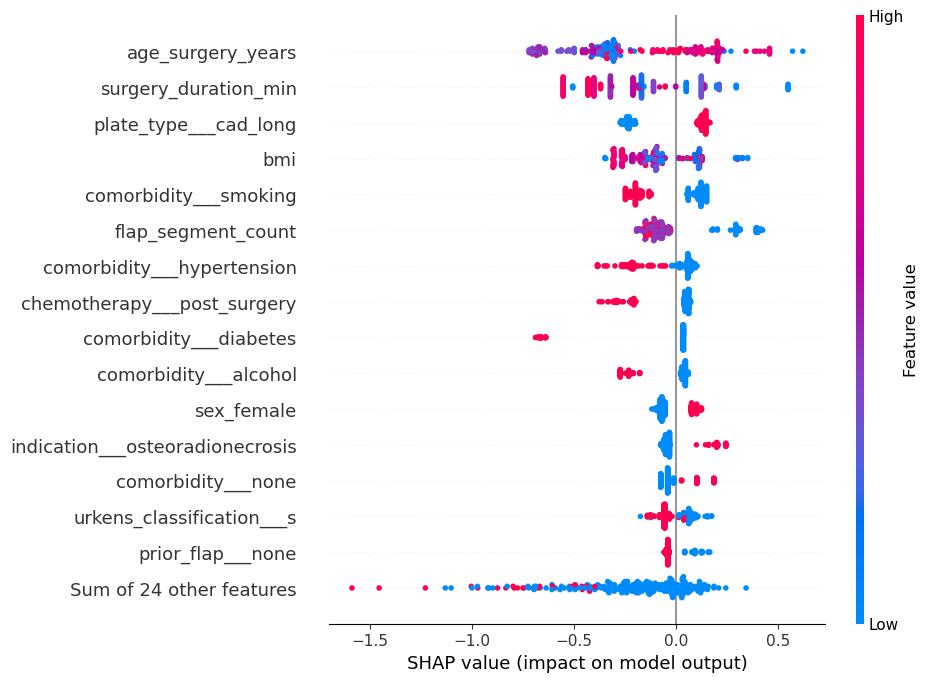

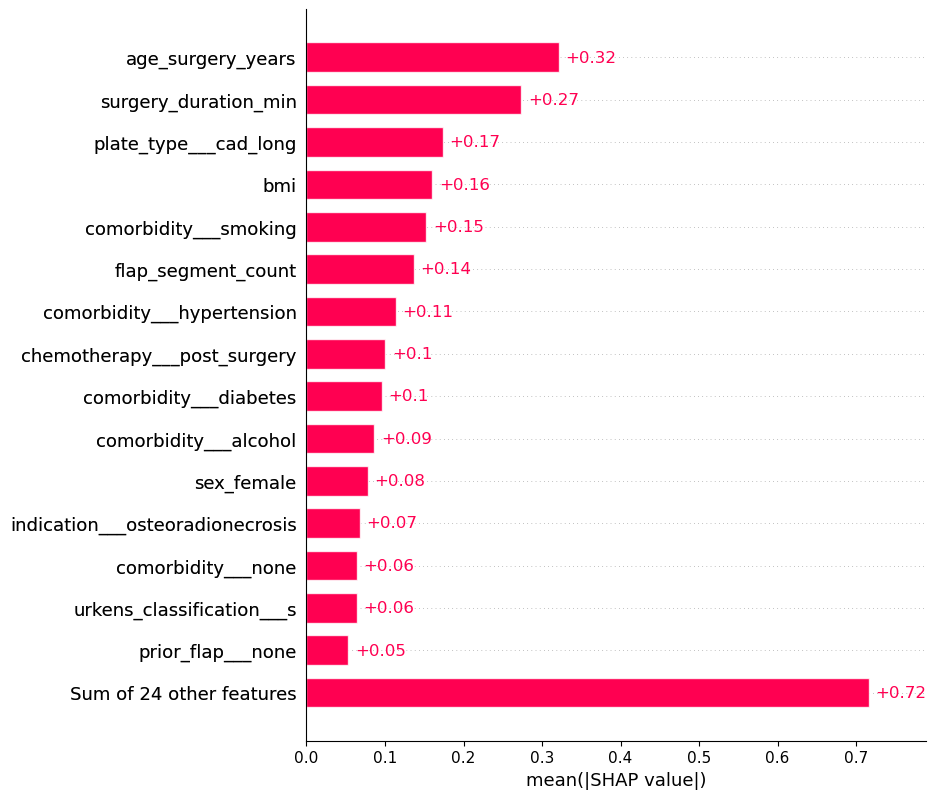

In [261]:
# OUTCOME VALUES ARE INVERSE
sv_xgb_any_cx = get_shap_xgb(params_xgb_any_cx, x_xgb_any_cx, y_xgb_any_cx)

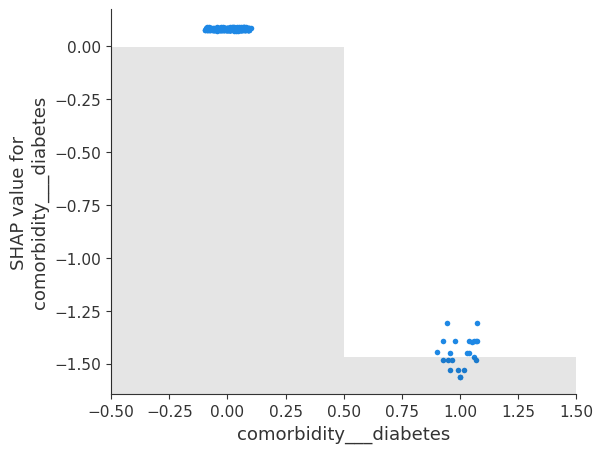

In [178]:
shap.plots.scatter(sv[:, 6])

#### Plate exposure

In [230]:
follow_up_plate_exp = df_all_levels_imp['days_to_plate_exposure'].median()
drop_cols_plate_exp = ['venous_anastomosis_type___end_side', 'venous_anastomosis_type___end_end']

##### Logistic Regression

###### Statsmodel
2

In [482]:
# Statsmodel LR
lr_statsmodels(
    outcome='complication_plate___exposure', 
    min_follow_up_days=follow_up_plate_exp, 
    scaler='None',
    df=df_dropped_first_imp, 
    drop_cols=drop_cols_plate_exp
)

Optimization terminated successfully.
         Current function value: 0.428257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415008
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430075
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.433790
         Iterations 7

Mean F1: 0.515 ± 0.034
Mean MCC: 0.339 ± 0.036
Mean Accuracy: 0.759 ± 0.010
Mean PR AUC: 0.371 ± 0.064
Mean ROC AUC: 0.671 ± 0.062

Optimization terminated successfully.
         Current function value: 0.437653
         Iterations 7
                                 Logit Regression Results                                
Dep. Variable:     complication_plate___exposure   No. Observations:                  261
Model:                                     Logit   Df Residuals:           

###### Newton

In [483]:
# Logistic Regression (newton-cholesky, newton-cg)
params_newton_plate_exp, x_newton_plate_exp, y_newton_plate_exp = nested_cv_optuna(
    outcome='complication_plate___exposure', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_plate_exp, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_newton_classifier,
    drop_cols=drop_cols_plate_exp
)

/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models


/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Optimized 5 out of 5 models

Mean F1: 0.510 ± 0.045
Mean MCC: 0.322 ± 0.065
Mean Accuracy: 0.755 ± 0.008
Mean PR AUC: 0.392 ± 0.041
Mean ROC AUC: 0.683 ± 0.034

All F1 scores: [0.5499999999999999, 0.4583333333333333, 0.5641025641025641, 0.4888888888888889, 0.48780487804878053]


###### Liblinear

In [484]:
# Liblinear Logistic Regression
params_liblinear_plate_exp, x_liblinear_plate_exp, y_liblinear_plate_exp = nested_cv_optuna(
    outcome='complication_plate___exposure', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_plate_exp, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_liblinear_classifier,
    drop_cols=drop_cols_plate_exp
)

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.505 ± 0.031
Mean MCC: 0.326 ± 0.056
Mean Accuracy: 0.755 ± 0.008
Mean PR AUC: 0.339 ± 0.040
Mean ROC AUC: 0.632 ± 0.057

All F1 scores: [0.5106382978723405, 0.4799999999999999, 0.5454545454545454, 0.5217391304347827, 0.46808510638297873]


In [ ]:
x_pe, y_pe = get_x_y(df=df_all_levels_imp, outcome='complication_plate___exposure', min_follow_up_days=follow_up_plate_exp, scaler=QuantileTransformer(n_quantiles=200, random_state=0))
for model in plt_exp_lib_models:
    model.fit(x_pe, y_pe)
    exp = shap.KernelExplainer(model.predict_proba, feature_names=x_pe.columns, data=shap.sample(x_pe, nsamples=5, random_state=0))
    sv = exp.shap_values(shap.sample(x_pe, nsamples=5, random_state=0))
    shap.summary_plot(sv, features=x_pe, max_display=7)

##### kNN
Worse than xgboost

In [485]:
params_knn_plate_exp, x_knn_plate_exp, y_knn_plate_exp = nested_cv_optuna(
    outcome='complication_plate___exposure', 
    model=KNeighborsClassifier(),
    min_follow_up_days=follow_up_plate_exp, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=knn_classifier,
    drop_cols=drop_cols_plate_exp
)

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.440 ± 0.021
Mean MCC: 0.249 ± 0.061
Mean Accuracy: 0.759 ± 0.022
Mean PR AUC: 0.332 ± 0.043
Mean ROC AUC: 0.584 ± 0.054

All F1 scores: [0.4528301886792453, 0.42105263157894735, 0.42105263157894735, 0.47058823529411764, 0.43636363636363634]


In [ ]:
x_pe, y_pe = get_x_y(df=df_all_levels_imp, outcome='complication_plate___exposure', min_follow_up_days=follow_up_plate_exp, scaler=QuantileTransformer(n_quantiles=200, random_state=0))
for model in plt_exp_knn_models:
    model.fit(x_pe, y_pe)
    exp = shap.Explainer(model.predict_proba, shap.sample(x_pe, nsamples=5, random_state=0))
    sv = exp.shap_values(shap.sample(x_pe, nsamples=5, random_state=0))
    #sv = exp(shap.sample(x_pe, nsamples=5, random_state=0))
    shap.plots.beeswarm(sv)

##### Random Forest
Worse than xgboost

In [486]:
params_rf_plate_exp, x_rf_plate_exp, y_rf_plate_exp = nested_cv_optuna(
    outcome='complication_plate___exposure', 
    model=RandomForestClassifier(n_estimators=500, random_state=0),
    min_follow_up_days=follow_up_plate_exp, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=rf_classifier,
    drop_cols=drop_cols_plate_exp
)

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.483 ± 0.033
Mean MCC: 0.282 ± 0.079
Mean Accuracy: 0.759 ± 0.010
Mean PR AUC: 0.373 ± 0.082
Mean ROC AUC: 0.642 ± 0.050

All F1 scores: [0.4905660377358491, 0.4888888888888888, 0.5217391304347827, 0.48, 0.4313725490196079]


In [531]:
avg_params_rf_plate_exp = get_avg_params(params_rf_plate_exp)

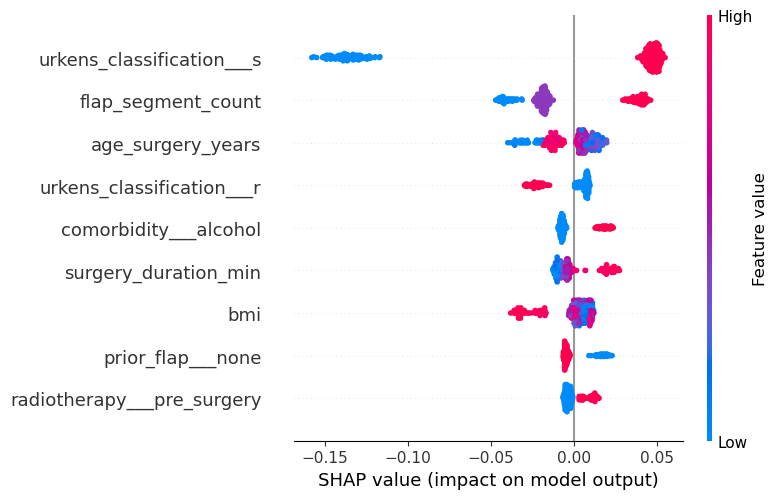

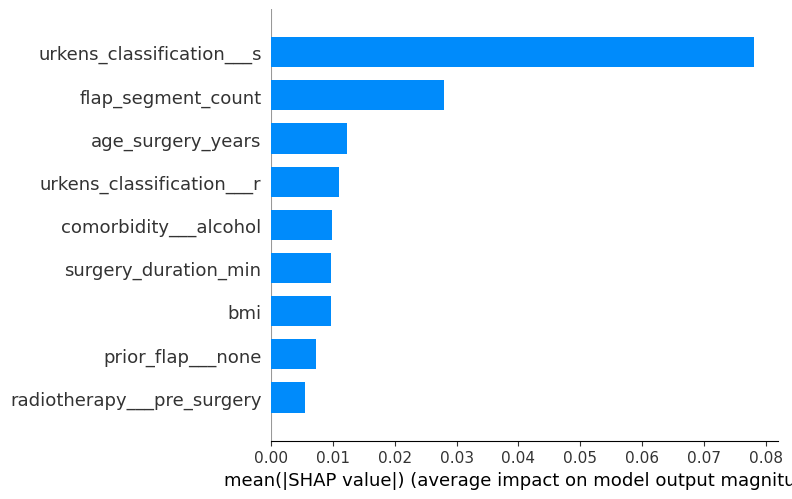

In [534]:
get_shap_rf([avg_params_rf_plate_exp], x_rf_plate_exp, y_rf_plate_exp)

##### XGBoost

1

In [487]:
params_xgb_plate_exp, x_xgb_plate_exp, y_xgb_plate_exp = nested_cv_optuna(
    outcome='complication_plate___exposure', 
    model=XGBClassifier(random_state=0, verbosity=0),
    min_follow_up_days=follow_up_plate_exp, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=xgb_classifier,
    drop_cols=drop_cols_plate_exp
)

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.524 ± 0.078
Mean MCC: 0.343 ± 0.140
Mean Accuracy: 0.762 ± 0.019
Mean PR AUC: 0.371 ± 0.124
Mean ROC AUC: 0.667 ± 0.134

All F1 scores: [0.5714285714285714, 0.5641025641025641, 0.6, 0.4615384615384615, 0.4210526315789474]


In [521]:
_= get_avg_params(params_xgb_plate_exp)

[20:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


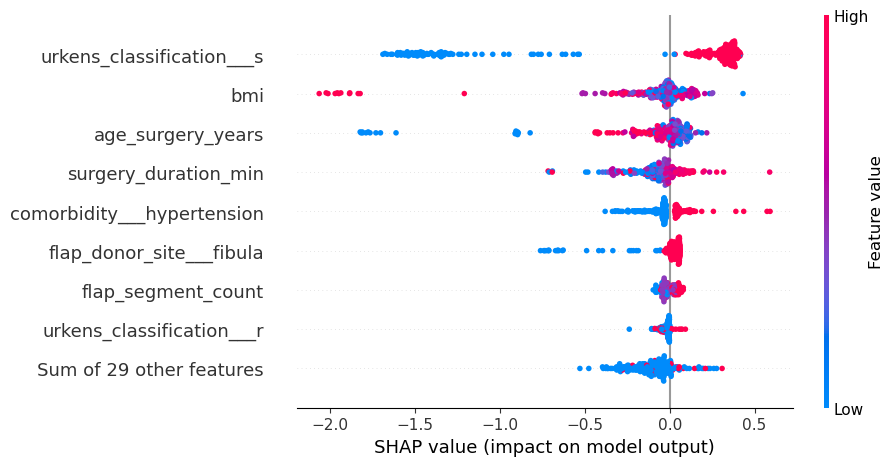

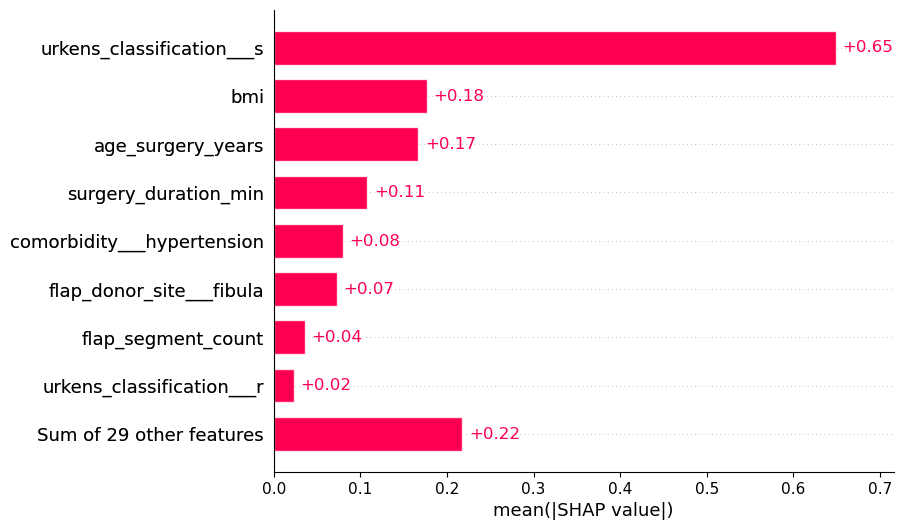

In [529]:
get_shap_xgb([_], x_xgb_plate_exp, y_xgb_plate_exp)

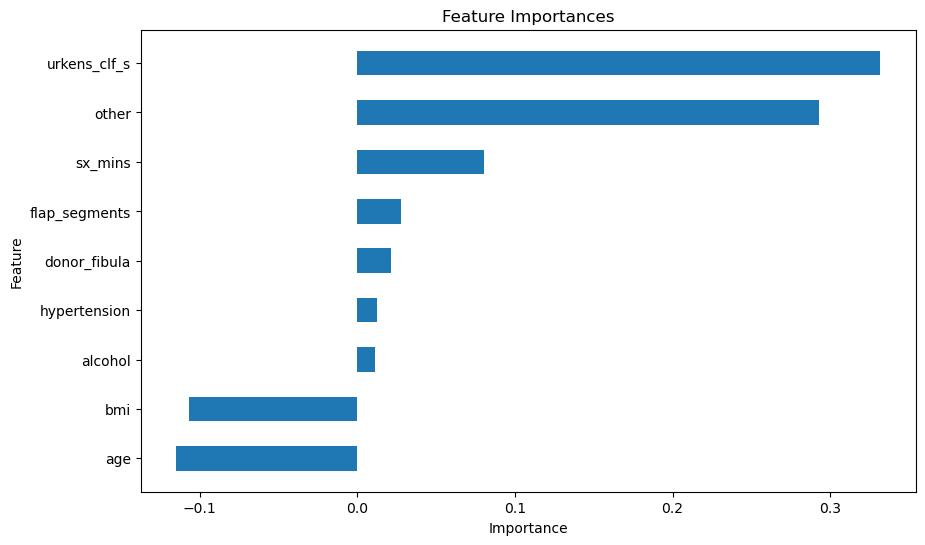

In [519]:
# Feature importances xgboost
xpe_1 = [0.39, 0.09, 0.08, 0.07, 0.06, 0.35]
xpe_2 = [0.52, 0.2, 0.18, 0.14, 0.08, 0.48]
xpe_3 = [0.7, 0.22, 0.18, 0.12, 0.1, 0.31]
xpe_4 = [0.47, 0.2, 0.18, 0.12, 0.09, 0.47]
xpe_5 = [0.77, 0.46, 0.35, 0.32, 0.17, 1.11]

urkens_clf_s = (xpe_1[0]/sum(xpe_1) + xpe_2[0]/sum(xpe_2) + xpe_3[0]/sum(xpe_3) + xpe_4[0]/sum(xpe_4) + xpe_5[0]/sum(xpe_5))/5
flap_segments = (xpe_1[1]/sum(xpe_1) + xpe_5[4]/sum(xpe_5))/5
bmi = (xpe_1[2]/sum(xpe_1) + xpe_2[1]/sum(xpe_2) + xpe_3[2]/sum(xpe_3) + xpe_4[2]/sum(xpe_4) + xpe_5[2]/sum(xpe_5))/5
sx_mins = (xpe_1[3]/sum(xpe_1) + xpe_2[3]/sum(xpe_2) + xpe_3[3]/sum(xpe_3) + xpe_4[3]/sum(xpe_4) + xpe_5[3]/sum(xpe_5))/5
age = (xpe_2[2]/sum(xpe_1) + xpe_3[1]/sum(xpe_3) + xpe_4[1]/sum(xpe_4) + xpe_5[1]/sum(xpe_5))/5
donor_fibula = (xpe_2[4]/sum(xpe_2) + xpe_4[4]/sum(xpe_4))/5
alcohol = (xpe_1[4]/sum(xpe_1))/5
hypertension = (xpe_3[4]/sum(xpe_3))/5
other = (xpe_1[5]/sum(xpe_1) + xpe_2[5]/sum(xpe_2) + xpe_3[5]/sum(xpe_3) + xpe_4[5]/sum(xpe_4) + xpe_5[5]/sum(xpe_5))/5

total_sum = urkens_clf_s+flap_segments+bmi+sx_mins+age+donor_fibula+alcohol+hypertension+other

plot = [urkens_clf_s/total_sum, flap_segments/total_sum, -bmi/total_sum, sx_mins/total_sum, -age/total_sum, donor_fibula/total_sum, alcohol/total_sum, hypertension/total_sum, other/total_sum]
        
labels = ['urkens_clf_s', 'flap_segments', 'bmi', 'sx_mins', 'age', 'donor_fibula', 'alcohol', 'hypertension', 'other']

plot, labels = zip(*sorted(zip(plot, labels), reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(range(len(plot)), plot, height=0.5)
plt.yticks(range(len(plot)), labels)  # Setting labels
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display bars in descending order
plt.show()

#### Nonunion

In [351]:
follow_up_nonunion = 0 
drop_cols_nonunion = 'skin_transplanted'

# No minimum follow-up since all patients without imaging data are excluded 
# as they have a NaN in the nonunion column

##### Logistic Regression

In [535]:
# Statsmodel LR
lr_statsmodels(
    outcome='nonunion', 
    min_follow_up_days=follow_up_nonunion, 
    scaler='None',
    df=df_dropped_first_imp, 
    drop_cols=drop_cols_nonunion
)

Optimization terminated successfully.
         Current function value: 0.560942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.583087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.568241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516582
         Iterations 6

Mean F1: 0.651 ± 0.037
Mean MCC: 0.276 ± 0.089
Mean Accuracy: 0.623 ± 0.057
Mean PR AUC: 0.566 ± 0.070
Mean ROC AUC: 0.582 ± 0.079

Optimization terminated successfully.
         Current function value: 0.582834
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               nonunion   No. Observations:                  202
Model:                          Logit   Df Residuals:                      170
Method:           

###### Newton

In [440]:
# Logistic Regression (lbfgs, newton-cholesky, newton-cg)
params_newton_nonunion, x_newton_nonunion, y_newton_nonunion = nested_cv_optuna(
    outcome='nonunion', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_nonunion,  
    #scaler=QuantileTransformer(n_quantiles=150, random_state=0),
    scaler='None',
    df=df_dropped_first_imp, 
    classifier=lr_newton_classifier,
    drop_cols=drop_cols_nonunion
)

/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Optimized 1 out of 5 models


/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Optimized 2 out of 5 models
Optimized 3 out of 5 models


/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.677 ± 0.039
Mean MCC: 0.298 ± 0.128
Mean Accuracy: 0.623 ± 0.066
Mean PR AUC: 0.588 ± 0.076
Mean ROC AUC: 0.606 ± 0.095

All F1 scores: [0.6818181818181819, 0.7234042553191489, 0.6296296296296297, 0.7037037037037037, 0.6440677966101694]


###### Liblinear

In [442]:
# Liblinear Logistic Regression
params_liblinear_nonunion, x_liblinear_nonunion, y_liblinear_nonunion = nested_cv_optuna(
    outcome='nonunion', 
    model=LogisticRegression(max_iter=1000),
    min_follow_up_days=follow_up_nonunion, 
    scaler=QuantileTransformer(n_quantiles=150, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_liblinear_classifier,
    drop_cols=drop_cols_nonunion
)

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.667 ± 0.041
Mean MCC: 0.294 ± 0.108
Mean Accuracy: 0.638 ± 0.059
Mean PR AUC: 0.581 ± 0.092
Mean ROC AUC: 0.616 ± 0.093

All F1 scores: [0.6511627906976745, 0.7083333333333333, 0.6206896551724138, 0.7111111111111111, 0.6440677966101694]


##### kNN

In [356]:
params_knn_nonunion, x_knn_nonunion, y_knn_nonunion = nested_cv_optuna(
    outcome='nonunion', 
    model=KNeighborsClassifier(),
    min_follow_up_days=follow_up_nonunion, 
    scaler=QuantileTransformer(n_quantiles=150, random_state=0), 
    df=df_all_levels_imp, 
    classifier=knn_classifier,
    drop_cols=drop_cols_nonunion
)

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.648 ± 0.019
Mean MCC: 0.219 ± 0.089
Mean Accuracy: 0.594 ± 0.036
Mean PR AUC: 0.522 ± 0.068
Mean ROC AUC: 0.555 ± 0.076

All F1 scores: [0.6440677966101694, 0.6440677966101694, 0.6206896551724138, 0.6666666666666666, 0.6666666666666666]


##### Random Forest

In [357]:
params_rf_nonunion, x_rf_nonunion, y_rf_nonunion = nested_cv_optuna(
    outcome='nonunion', 
    model=RandomForestClassifier(random_state=0),
    min_follow_up_days=follow_up_nonunion, 
    scaler=QuantileTransformer(n_quantiles=150, random_state=0), 
    df=df_all_levels_imp, 
    classifier=rf_classifier,
    drop_cols=drop_cols_nonunion
)

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.646 ± 0.021
Mean MCC: 0.212 ± 0.047
Mean Accuracy: 0.589 ± 0.031
Mean PR AUC: 0.547 ± 0.033
Mean ROC AUC: 0.585 ± 0.054

All F1 scores: [0.6428571428571428, 0.6440677966101694, 0.6206896551724138, 0.679245283018868, 0.6440677966101694]


##### XGBoost

In [536]:
params_xgb_nu, x_xgb_nu, y_xgb_nu = nested_cv_optuna(
    outcome='nonunion', 
    model=XGBClassifier(),
    min_follow_up_days=follow_up_nonunion, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=xgb_classifier,
    drop_cols=drop_cols_nu
)

Optimized 1 out of 5 models
Optimized 2 out of 5 models
Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.661 ± 0.024
Mean MCC: 0.238 ± 0.084
Mean Accuracy: 0.589 ± 0.038
Mean PR AUC: 0.547 ± 0.088
Mean ROC AUC: 0.568 ± 0.078

All F1 scores: [0.6799999999999999, 0.6440677966101694, 0.6428571428571429, 0.6923076923076923, 0.6440677966101694]


In [537]:
avg_params_xgb_nu = get_avg_params(params_xgb_nu)

[21:08:30] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


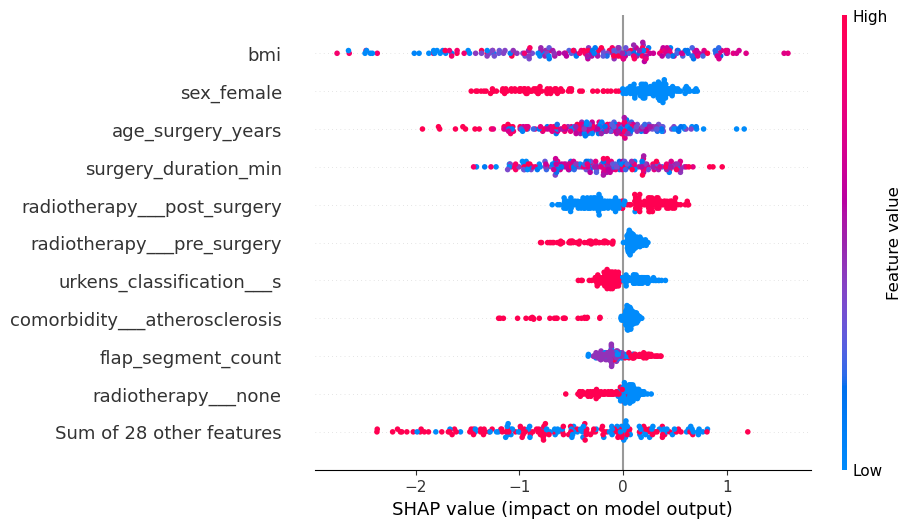

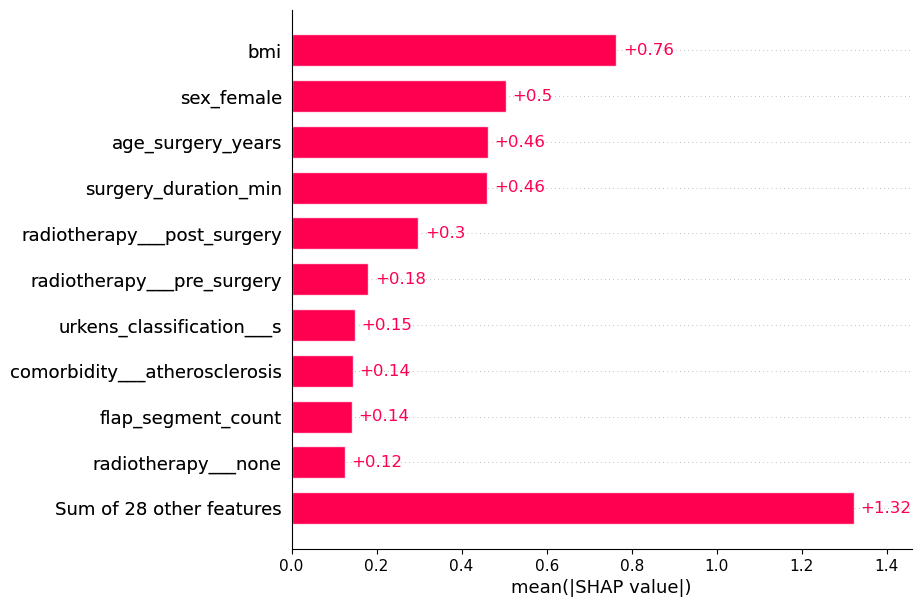

In [542]:
get_shap_xgb([avg_params_xgb_nu], x_xgb_nu, y_xgb_nu)

#### Soft tissue complication

In [210]:
follow_up_stx = np.mean([
    df_all_levels_imp['days_to_whd_recipient_site'].median(),
     df_all_levels_imp['days_to_partial_necrosis'].median(),
     df_all_levels_imp['days_to_bone_exposure'].median(),
     df_all_levels_imp['days_to_plate_exposure'].median(),
     df_all_levels_imp['days_to_wound_infection'].median()
])

drop_cols_stx = []

##### Logistic Regression

In [456]:
# Statsmodel LR
lr_statsmodels(
    outcome='soft_tissue_complication', 
    min_follow_up_days=follow_up_stx, 
    scaler='None',
    df=df_dropped_first_imp, 
    drop_cols=drop_cols_stx
)

IMPORTANT: The outcome value was inversed due to the positive class being more frequent than the negative class. High SHAP values predict the non-occurence.

Optimization terminated successfully.
         Current function value: 0.565386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.559141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.554834
         Iterations 6

Mean F1: 0.688 ± 0.033
Mean MCC: 0.338 ± 0.076
Mean Accuracy: 0.653 ± 0.041
Mean PR AUC: 0.648 ± 0.058
Mean ROC AUC: 0.641 ± 0.057

Optimization terminated successfully.
         Current function value: 0.572223
         Iterations 6
                              Logit Regression Results                              
Dep. Variabl

In [ ]:
# Logistic Regression (lbfgs, newton-cholesky, newton-cg)
nested_cv_optuna(
    outcome='soft_tissue_complication', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_stx,  
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_lnn_classifier
)

In [ ]:
# Liblinear Logistic Regression
nested_cv_optuna(
    outcome='soft_tissue_complication', 
    model=LogisticRegression(max_iter=1000),
    min_follow_up_days=follow_up_stx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_liblinear_classifier
)

##### kNN

In [ ]:
nested_cv_optuna(
    outcome='soft_tissue_complication', 
    model=KNeighborsClassifier(),
    min_follow_up_days=follow_up_stx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=knn_classifier
)

##### Random Forest

In [ ]:
nested_cv_optuna(
    outcome='soft_tissue_complication', 
    model=RandomForestClassifier(random_state=0),
    min_follow_up_days=follow_up_stx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=rf_classifier
)

##### XGBoost

In [211]:
params_xgb_stx, x_xgb_stx, y_xgb_stx = nested_cv_optuna(
    outcome='soft_tissue_complication', 
    model=XGBClassifier(),
    min_follow_up_days=follow_up_stx, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=xgb_classifier,
    drop_cols=drop_cols_stx
)

Mean MCC: 0.414 ± 0.086
Mean F1: 0.712 ± 0.044
Mean Accuracy: 0.698 ± 0.045
Mean PR AUC: 0.703 ± 0.051
Mean ROC AUC: 0.699 ± 0.052


[23:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


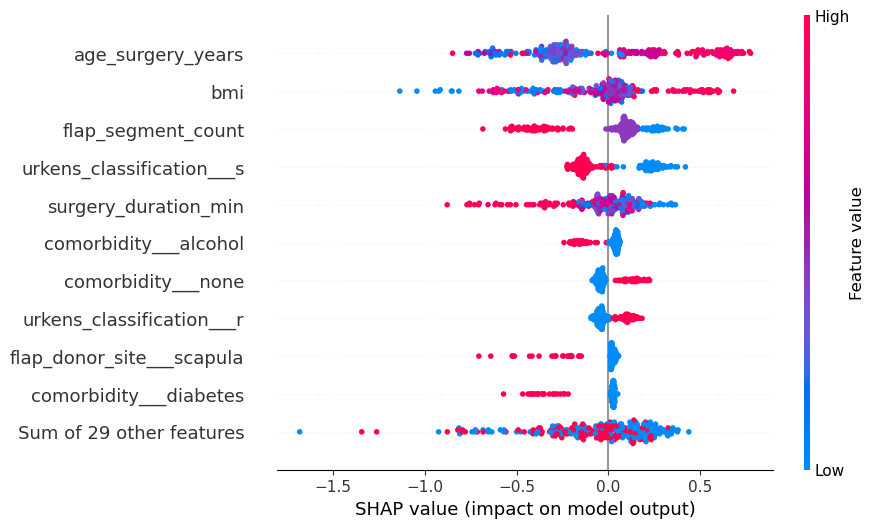

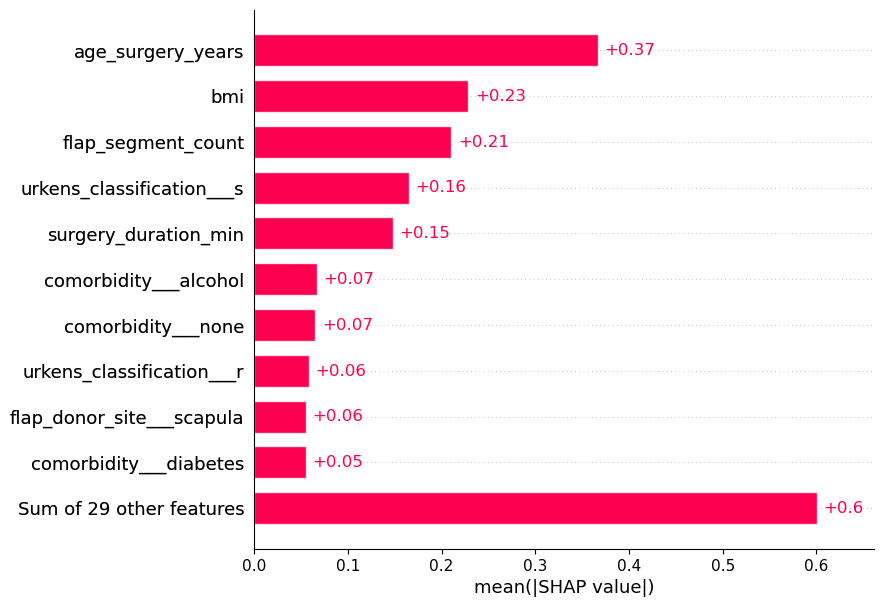

In [212]:
sv_xgb_stx = get_shap_xgb(params_xgb_stx, x_xgb_stx, y_xgb_stx)

#### Wound infection

In [213]:
follow_up_wi = df_all_levels_imp['days_to_wound_infection'].median()
drop_cols_wi = []

##### Logistic Regression

In [457]:
# Statsmodel LR
lr_statsmodels(
    outcome='wound_infection', 
    min_follow_up_days=follow_up_wi, 
    scaler='None',
    df=df_dropped_first_imp, 
    drop_cols=drop_cols_wi
)

Optimization terminated successfully.
         Current function value: 0.504978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498317
         Iterations 6

Mean F1: 0.456 ± 0.035
Mean MCC: 0.209 ± 0.088
Mean Accuracy: 0.726 ± 0.008
Mean PR AUC: 0.327 ± 0.038
Mean ROC AUC: 0.523 ± 0.063

Optimization terminated successfully.
         Current function value: 0.525015
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        wound_infection   No. Observations:                  270
Model:                          Logit   Df Residuals:                      237
Method:           

In [ ]:
# Logistic Regression (lbfgs, newton-cholesky, newton-cg)
nested_cv_optuna(
    outcome='wound_infection', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_lnn_classifier
)

In [ ]:
# Liblinear Logistic Regression
nested_cv_optuna(
    outcome='wound_infection', 
    model=LogisticRegression(max_iter=1000, random_state=0),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_liblinear_classifier
)

##### kNN

In [ ]:
nested_cv_optuna(
    outcome='wound_infection', 
    model=KNeighborsClassifier(),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=knn_classifier
)

##### Random Forest

In [ ]:
nested_cv_optuna(
    outcome='wound_infection', 
    model=RandomForestClassifier(random_state=0),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=rf_classifier
)

##### XGBoost

In [214]:
params_xgb_wi, x_xgb_wi, y_xgb_wi = nested_cv_optuna(
    outcome='wound_infection', 
    model=XGBClassifier(random_state=0, verbosity=0),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=xgb_classifier,
    drop_cols=drop_cols_wi
)

Mean MCC: 0.196 ± 0.108
Mean F1: 0.434 ± 0.025
Mean Accuracy: 0.733 ± 0.025
Mean PR AUC: 0.369 ± 0.102
Mean ROC AUC: 0.491 ± 0.148


[23:46:17] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


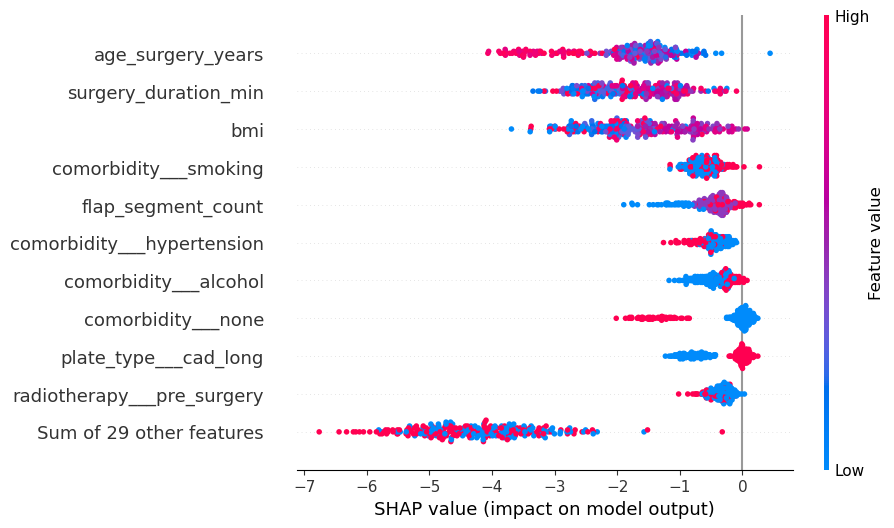

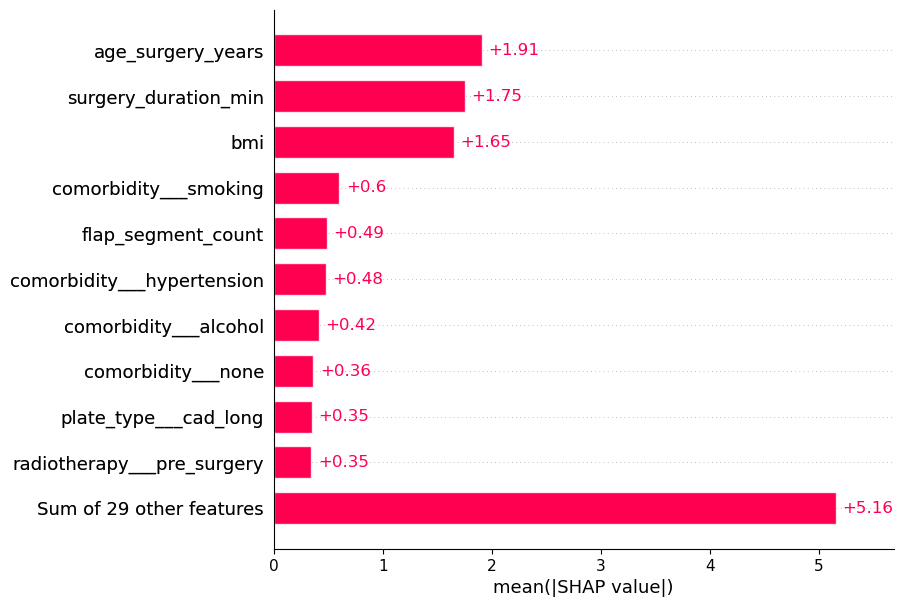

In [215]:
sv_xgb_wi = get_shap_xgb(params_xgb_wi, x_xgb_wi, y_xgb_wi)

#### Fistula

In [458]:
follow_up_fistula = follow_up_wi
drop_cols_fistula = drop_cols_wi

##### Logistic Regression

In [459]:
# Statsmodel LR
lr_statsmodels(
    outcome='infectious_complication___fistula', 
    min_follow_up_days=follow_up_fistula, 
    scaler='None',
    df=df_dropped_first_imp, 
    drop_cols=drop_cols_fistula
)

Optimization terminated successfully.
         Current function value: 0.435625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.424284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428082
         Iterations 7

Mean F1: 0.365 ± 0.044
Mean MCC: 0.152 ± 0.059
Mean Accuracy: 0.797 ± 0.002
Mean PR AUC: 0.249 ± 0.058
Mean ROC AUC: 0.513 ± 0.080

Optimization terminated successfully.
         Current function value: 0.444377
         Iterations 6
                                   Logit Regression Results                                  
Dep. Variable:     infectious_complication___fistula   No. Observations:                  271
Model:                                         Logit   Df Residuals

In [464]:
# Logistic Regression (newton-cholesky, newton-cg)
params_newton_fistula, x_newton_fistula, y_newton_fistula = nested_cv_optuna(
    outcome='infectious_complication___fistula', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_newton_classifier,
    drop_cols=drop_cols_fistula
)

/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Optimized 1 out of 5 models
Optimized 2 out of 5 models


/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/philipp.lampert/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Optimized 3 out of 5 models
Optimized 4 out of 5 models
Optimized 5 out of 5 models

Mean F1: 0.384 ± 0.033
Mean MCC: 0.178 ± 0.087
Mean Accuracy: 0.801 ± 0.010
Mean PR AUC: 0.285 ± 0.066
Mean ROC AUC: 0.557 ± 0.063

All F1 scores: [0.4, 0.3555555555555555, 0.3902439024390244, 0.42857142857142855, 0.34782608695652173]


In [ ]:
# Liblinear Logistic Regression
nested_cv_optuna(
    outcome='infectious_complication___fistula', 
    model=LogisticRegression(max_iter=1000, random_state=0),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_liblinear_classifier
)

##### kNN

In [ ]:
nested_cv_optuna(
    outcome='infectious_complication___fistula', 
    model=KNeighborsClassifier(),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=knn_classifier
)

##### Random Forest

In [ ]:
nested_cv_optuna(
    outcome='infectious_complication___fistula', 
    model=RandomForestClassifier(random_state=0),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=rf_classifier
)

##### XGBoost

In [ ]:
fistula_xgb_models, x_fistula, y_fistula = nested_cv_optuna(
    outcome='infectious_complication___fistula', 
    model=XGBClassifier(random_state=0, verbosity=0),
    min_follow_up_days=follow_up_wi, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=xgb_classifier
)

In [ ]:
get_shap_xgb(fistula_xgb_models, x_fistula, y_fistula)

#### Flap loss
No prediction possible - Not enough positives.

In [220]:
follow_up_fl = 0
drop_cols_fl = ['radiotherapy___post_surgery', 'chemotherapy___post_surgery']

##### Logistic Regression

In [ ]:
# Statsmodel LR
# Did not converge
lr_statsmodels(
    outcome='flap_loss', 
    min_follow_up_days=follow_up_fl, 
    scaler='None',
    df=df_dropped_first_imp, 
    drop_cols=drop_cols_fl
)

In [ ]:
# Logistic Regression (lbfgs, newton-cholesky, newton-cg)
# Did not converge
nested_cv_optuna(
    outcome='flap_loss', 
    model=LogisticRegression(max_iter=10000, random_state=0),
    min_follow_up_days=follow_up_fl, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_lnn_classifier
)

In [ ]:
# Liblinear Logistic Regression
nested_cv_optuna(
    outcome='flap_loss', 
    model=LogisticRegression(max_iter=1000, random_state=0),
    min_follow_up_days=follow_up_fl, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_dropped_first_imp, 
    classifier=lr_liblinear_classifier
)

##### kNN

In [ ]:
nested_cv_optuna(
    outcome='flap_loss', 
    model=KNeighborsClassifier(),
    min_follow_up_days=follow_up_fl, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=knn_classifier
)

##### Random Forest

In [ ]:
nested_cv_optuna(
    outcome='flap_loss', 
    model=RandomForestClassifier(random_state=0),
    min_follow_up_days=follow_up_fl, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=rf_classifier
)

##### XGBoost

In [221]:
params_xgb_fl, x_xgb_fl, y_xgb_fl = nested_cv_optuna(
    outcome='flap_loss', 
    model=XGBClassifier(random_state=0, verbosity=0),
    min_follow_up_days=follow_up_fl, 
    scaler=QuantileTransformer(n_quantiles=200, random_state=0), 
    df=df_all_levels_imp, 
    classifier=xgb_classifier,
    drop_cols=drop_cols_fl
)

Mean MCC: 0.219 ± 0.177
Mean F1: 0.243 ± 0.121
Mean Accuracy: 0.948 ± 0.007
Mean PR AUC: 0.160 ± 0.119
Mean ROC AUC: 0.533 ± 0.142


[23:52:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


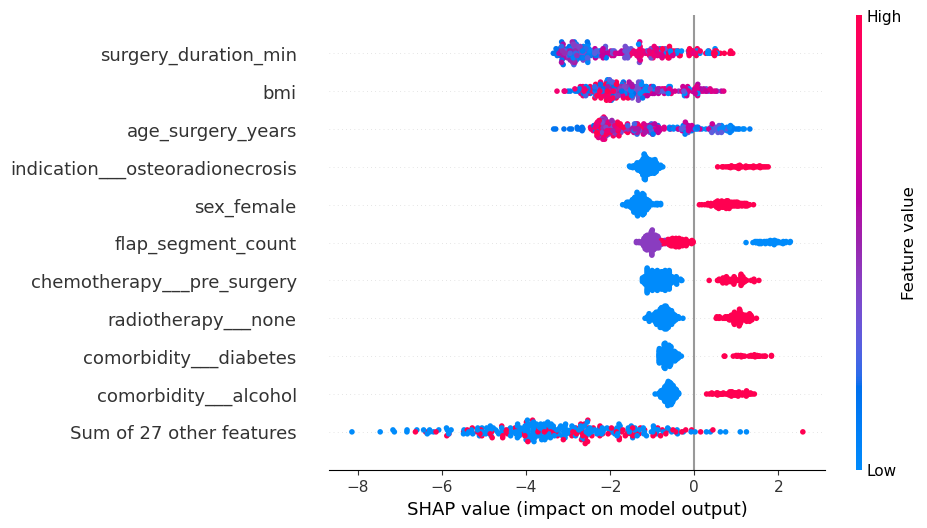

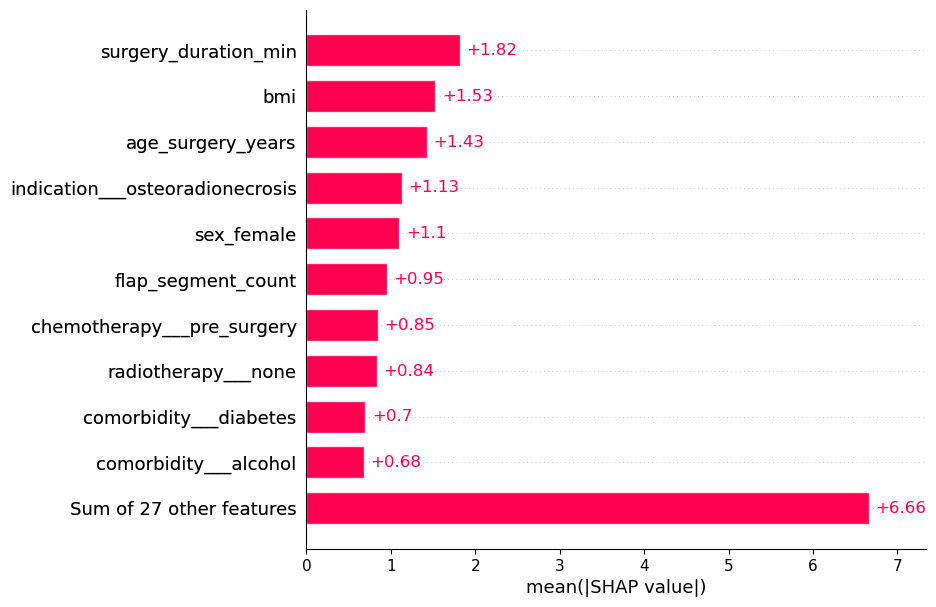

In [222]:
sv_xgb_fl = get_shap_xgb(params_xgb_fl, x_xgb_fl, y_xgb_fl)